# Underfitting vs Overfitting

Underfitting : le modèle est trop simple pour capturer la structure des données (ex. frontière linéaire pour des données en forme de lune).
Overfitting : le modèle est trop flexible et s'adapte au bruit et aux détails du jeu d'entraînement, perdant la capacité de généraliser.

Les graphiques suivants montrent, pour un jeu de données `make_moons` :
 - Pour chaque cas (Underfitting, Overfitting, Cas optimal), la frontière de décision sur les données d'entraînement (ligne du haut) et sur les données de test (ligne du bas).
 - Au total : 6 graphiques (underfit train/test, overfit train/test, optimal train/test).

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [65]:
# Génération du jeu de données (cellule dédiée)
X_all, y_all = make_moons(n_samples=300, noise=0.25, random_state=0)

In [66]:
# Split 70% train / 30% test (cellule dédiée au split)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42, stratify=y_all)

# Utiliser le jeu complet pour calculer les bornes de tracé utilisées par plot_decision_boundary
X = X_all
y = y_all

In [67]:
def plot_decision_boundary(ax, model, X_pts, y_pts, title):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X_pts[:,0], X_pts[:,1], c=y_pts, edgecolor='k', cmap='coolwarm')
    ax.set_title(title)

In [68]:
# Modèles : underfit (linéaire), overfit (arbre très profond), optimal (forêt modérée)
logreg = LogisticRegression(max_iter=1000, random_state=0)
tree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=0)  # devenu très flexible pour sur-apprendre
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)

logreg.fit(X_train, y_train)
tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [69]:
from sklearn.metrics import accuracy_score

# Calcul des accuracies pour afficher le gap train vs test
models = {'LogReg': logreg, 'Tree': tree, 'RF': rf}
train_scores = {name: accuracy_score(y_train, model.predict(X_train)) for name, model in models.items()}
test_scores = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}
print('Train accs:', {k: f'{v:.2f}' for k,v in train_scores.items()})
print('Test accs :', {k: f'{v:.2f}' for k,v in test_scores.items()})

Train accs: {'LogReg': '0.84', 'Tree': '1.00', 'RF': '0.98'}
Test accs : {'LogReg': '0.82', 'Tree': '0.87', 'RF': '0.91'}


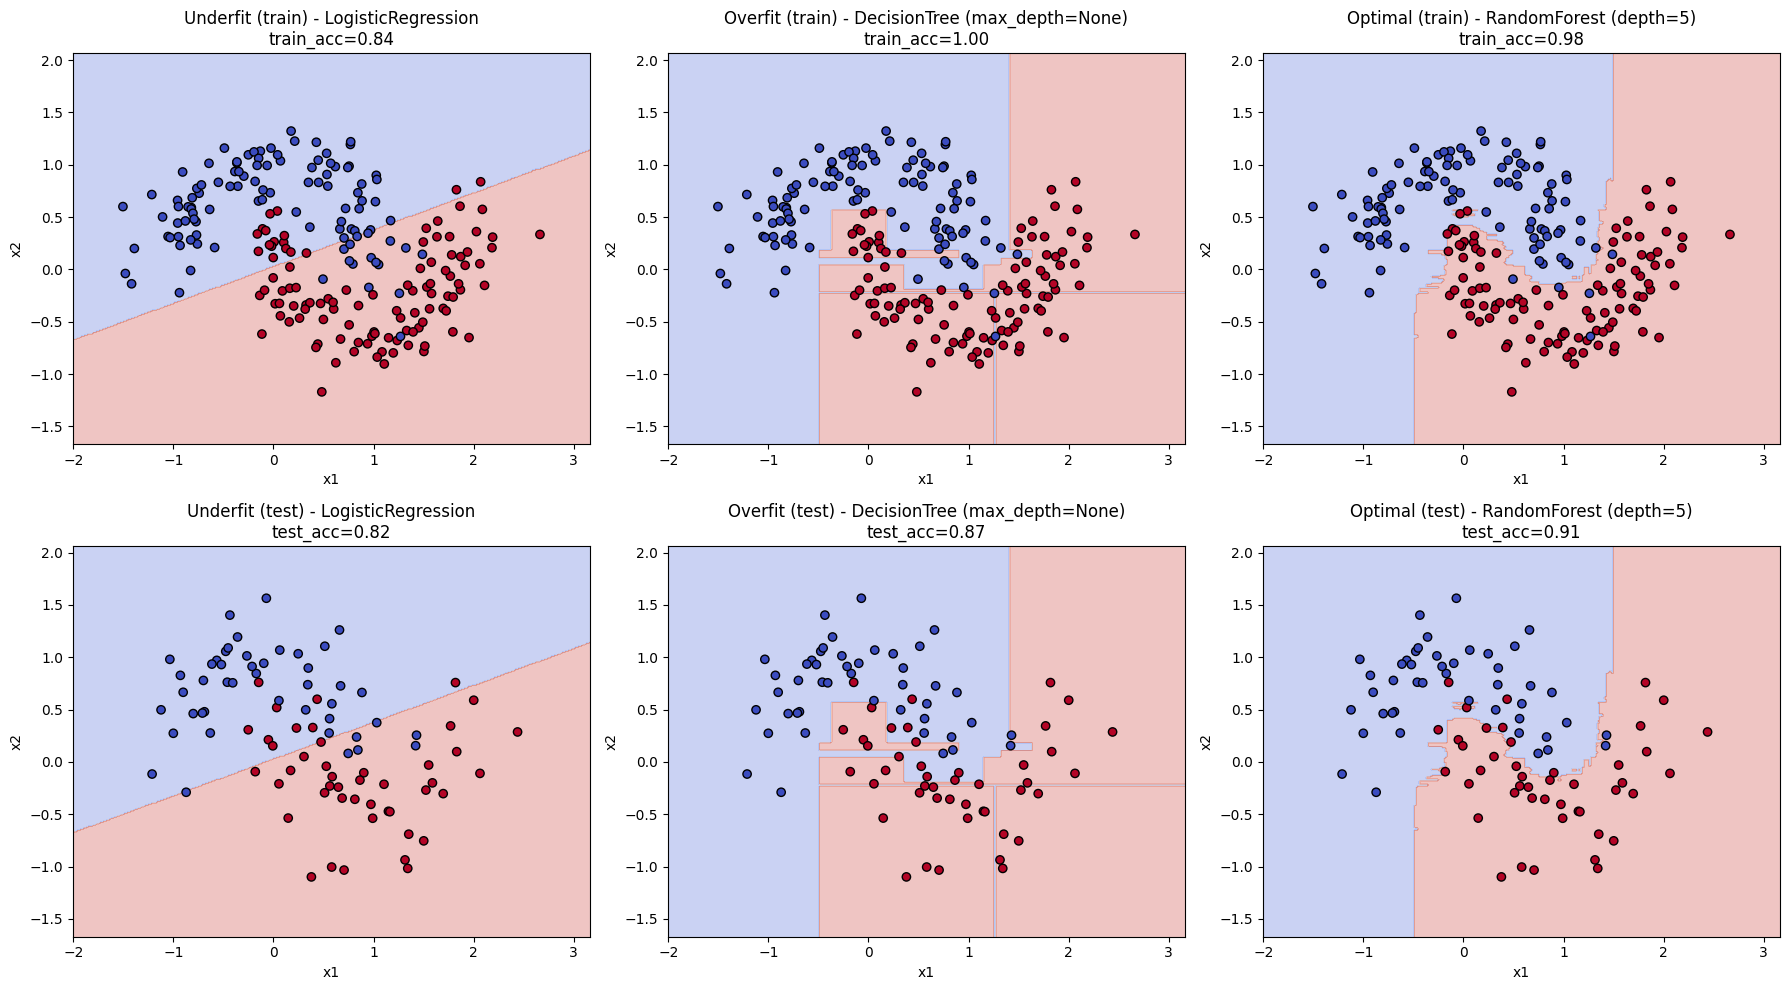

In [70]:
# Tracé 3 colonnes x 2 lignes : train (haut), test (bas)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

plot_decision_boundary(axes[0,0], logreg, X_train, y_train, f'Underfit (train) - LogisticRegression\ntrain_acc={train_scores["LogReg"]:.2f}')
plot_decision_boundary(axes[0,1], tree, X_train, y_train, f'Overfit (train) - DecisionTree (max_depth=None)\ntrain_acc={train_scores["Tree"]:.2f}')
plot_decision_boundary(axes[0,2], rf, X_train, y_train, f'Optimal (train) - RandomForest (depth=5)\ntrain_acc={train_scores["RF"]:.2f}')

plot_decision_boundary(axes[1,0], logreg, X_test, y_test, f'Underfit (test) - LogisticRegression\ntest_acc={test_scores["LogReg"]:.2f}')
plot_decision_boundary(axes[1,1], tree, X_test, y_test, f'Overfit (test) - DecisionTree (max_depth=None)\ntest_acc={test_scores["Tree"]:.2f}')
plot_decision_boundary(axes[1,2], rf, X_test, y_test, f'Optimal (test) - RandomForest (depth=5)\ntest_acc={test_scores["RF"]:.2f}')

for ax in axes.ravel():
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.tight_layout()
plt.show()

Interprétation rapide :
- Underfitting : frontière trop simple, erreurs sur train et test (mauvaise capacité d'ajustement).
- Overfitting : frontière très irrégulière, généralement bonne performance sur train mais dégradée sur test (surapprentissage).
- Cas optimal : bonne balance entre ajustement et généralisation (bonne performance sur train et test).

Ajuster la complexité du modèle (régularisation, profondeur, nombre d'arbres, etc.) permet de tendre vers le cas optimal.

## Biais et variance — explication générale et formulation mathématique

### Explication générale

- Biais : erreur systématique due au modèle (capacité insuffisante). Un modèle avec un biais élevé ne peut pas représenter la vraie relation (underfitting).
- Variance : sensibilité du modèle aux variations du jeu d'entraînement. Un modèle avec une variance élevée change beaucoup selon l'échantillon (overfitting).

### Décomposition biais‑variance (forme simplifiée)

Pour un point x, la performance quadratique moyenne d'un estimateur \hat{f}(x) :

E_{train}[(y - \hat{f}(x))^2] = (Bias[\hat{f}(x)])^2 + Var[\hat{f}(x)] + \sigma^2

où :
- Bias[\hat{f}(x)] = E_{train}[\hat{f}(x)] - f_true(x) (écart moyen à la vraie fonction),
- Var[\hat{f}(x)] = E_{train}[(\hat{f}(x) - E_{train}[\hat{f}(x)])^2] (dispersion des prédictions),
- σ^2 représente le bruit irréductible dans les observations.

### Interprétation et conséquences pratiques

- Modèles simples → biais élevé, variance faible. Modèles complexes → biais faible, variance élevée.
- Objectif : trouver le compromis biais/variance qui minimise l'erreur totale (via validation, régularisation, augmentation de données, etc.).
- Les méthodes de régularisation (L2, dropout, early stopping, data augmentation) réduisent principalement la variance; augmenter la capacité ou réduire la régularisation réduit le biais.

En pratique, on ajuste la complexité du modèle et les hyperparamètres (p.ex. λ pour L2, learning rate, nombre d'unités) en validant pour atteindre le meilleur trade‑off biais/variance.

## Régularisation — formulations mathématiques et effets

- **L2 (weight decay)** : on minimise J(w)=L_data(w)+\frac{\lambda}{2}\|w\|_2^2.

- **L1** : J(w)=L_data(w)+\lambda\|w\|_1.

- **Dropout (réseaux)** : pendant l'entraînement, appliquer un masque binaire m_i ~ Bernoulli(p) aux activations a_i.

- **Batch Normalization** : pour un mini-batch B, normaliser x:

- **Gradient descent & learning rate (η)** : mise à jour simple

- **Early stopping** : on arrête l'entraînement à l'époque t* qui minimise la perte de validation L_val(t). Pas de formule unique, méthode empirique très efficace pour éviter l'overfitting.

- **Data augmentation** : on enrichit l'ensemble d'entraînement en échantillonnant des transformations T ~ S (p.ex. rotations, translations, bruit). Forme générale : x' = T(x), y' = y. Augmente la diversité et réduit l'overfitting.

### Comment ces méthodes adressent under/overfitting (résumé mathématique)
- Overfitting : large variance. Réduire la capacité effective ou contraindre les paramètres (L2/L1), ajouter bruit structurel (dropout, augmentation), ou stopper tôt (early stopping) diminue la variance de l'estimateur.
- Underfitting : biais élevé. Augmenter la capacité du modèle, diminuer la pénalité λ, ou permettre plus d'itérations / ajuster η pour assurer convergence permet de réduire le biais.
- Interaction LR ↔ régularisation : par ex. weight decay multiplie w par (1-ηλ) à chaque pas — l'effet dépend donc de η; choisir simultanément η et λ est requis pour un bon compromis biais/variance.eurs résultats.

### Learning rate

- **Définition** : amplitude des mises à jour des poids à chaque pas de gradient. Contrôle la vitesse d'apprentissage et la stabilité.
- **Trop élevé** : mises à jour instables, oscillations ou divergence (peut empêcher la convergence → faux signal d'underfitting si l'entraînement n'atteint pas un bon minimum).
- **Trop faible** : convergence très lente, risque de rester sur un mauvais minimum ou d'underfitting si l'entraînement est interrompu trop tôt.
- **Schedules / decay / warmup** : réduire le learning rate au fur et à mesure (ou utiliser warmup) permet d'explorer rapidement puis d'affiner, ce qui aide la généralisation.
- **Weight decay dans l'optimiseur** : souvent implémenté comme paramètre de l'optimiseur (équivalent à L2) — agit directement comme régulariseur.

### Comment ces méthodes répondent à l'underfitting / overfitting

- Pour lutter contre l'**overfitting** : appliquer L2/L1, dropout, augmenter les données, early stopping, et utiliser un learning rate et un schedule appropriés (un LR trop grand peut introduire du bruit, mais un LR modéré + decay stabilise et favorise généralisation).
- Pour lutter contre l'**underfitting** : augmenter la capacité du modèle (plus de paramètres), réduire la force de régularisation, augmenter le temps d'entraînement (ou augmenter le learning rate si l'entraînement stagnait), et vérifier que la convergence est atteinte.
- Remarque pratique : le learning rate interagit avec la régularisation — p.ex. un LR élevé avec weight decay peut avoir un effet régularisant, tandis qu'un LR trop bas peut masquer la capacité réelle du modèle (donnant l'impression d'underfitting).

Combiner plusieurs méthodes (p.ex. weight decay + dropout + early stopping + schedule de LR) est souvent la meilleure stratégie pour obtenir une bonne généralisation.

In [71]:
# Exemples — préparation : imports légers, RNG et définition des configurations 'Avant'/'Après'
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np

rng = np.random.RandomState(0)

# Définir les paires (Avant, Après) pour démonstration
methods = [
    ('L2', LogisticRegression(C=0.01, penalty='l2', max_iter=1000, random_state=0),
           LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=0)),
    ('L1', LogisticRegression(C=0.01, penalty='l1', solver='saga', max_iter=2000, random_state=0),
           LogisticRegression(C=1.0, penalty='l1', solver='saga', max_iter=2000, random_state=0)),
    ('EarlyStopping (MLP)', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, early_stopping=False, random_state=0),
                                       MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, random_state=0)),
    ('Learning rate (MLP)', MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=1.0, max_iter=500, random_state=0),
                                     MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, random_state=0)),
]

/home/codenam/projects/ml-exercises/algorithm-exercises/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codenam/projects/ml-exercises/algorithm-exercises/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codenam/projects/ml-exercises/algorithm-exercises/.venv/lib/python3.12/site-packages/sklearn/linear_mode

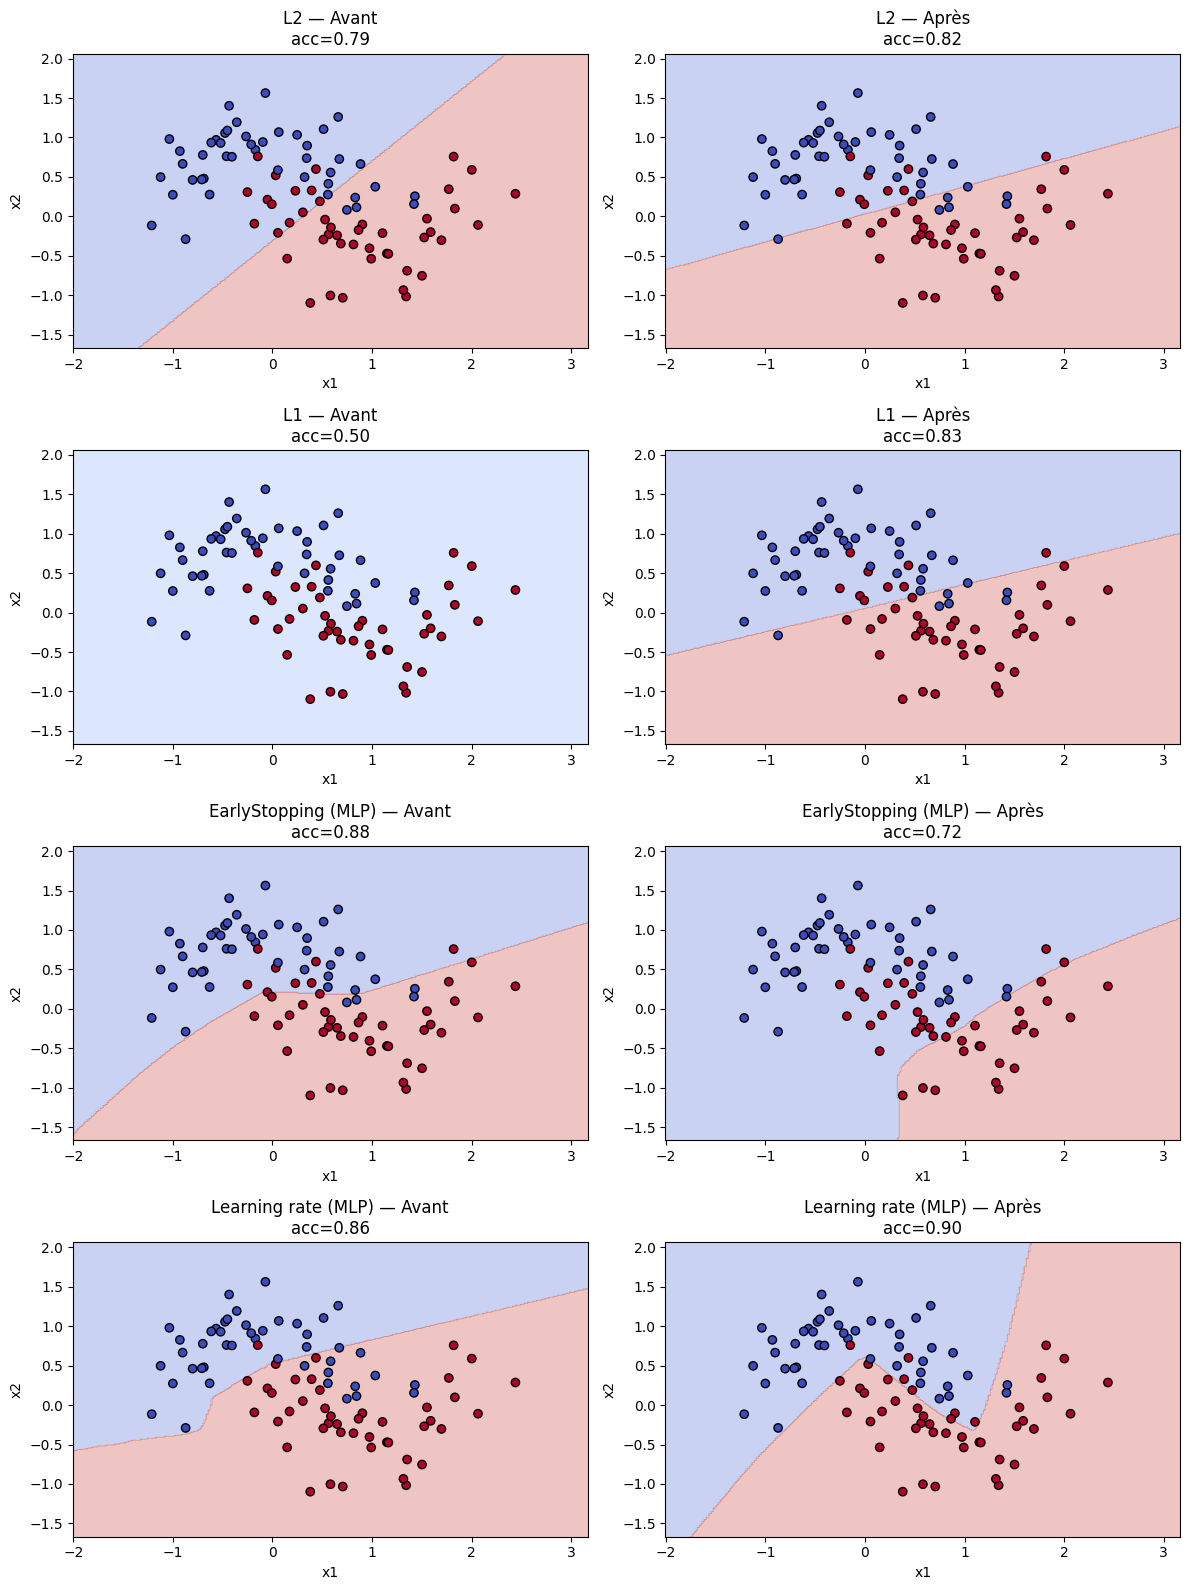

In [72]:
# Exemples — exécution : entraîner chaque paire et tracer Avant / Après
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(methods), 2, figsize=(12, 4*len(methods)))

for i, (name, before_model, after_model) in enumerate(methods):
    # fit before/after on training set
    before_model.fit(X_train, y_train)
    before_acc = (before_model.predict(X_test) == y_test).mean()
    after_model.fit(X_train, y_train)
    after_acc = (after_model.predict(X_test) == y_test).mean()

    # Affichage: Avant (gauche) / Après (droite) avec accuracies
    plot_decision_boundary(axes[i,0], before_model, X_test, y_test, f'{name} — Avant\nacc={before_acc:.2f}')
    plot_decision_boundary(axes[i,1], after_model, X_test, y_test, f'{name} — Après\nacc={after_acc:.2f}')
    axes[i,0].set_xlabel('x1'); axes[i,0].set_ylabel('x2')
    axes[i,1].set_xlabel('x1'); axes[i,1].set_ylabel('x2')

plt.tight_layout()
plt.show()

## Analyse des résultats — interprétation par méthode

### L2 (weight decay)
- Observation : la frontière "Après" est généralement plus lisse; l'accuracy de test augmente ou reste stable par rapport à "Avant".
- Interprétation : L2 réduit la magnitude des poids, diminue la variance et atténue les structures trop complexes apprises sur le train (réduction de l'overfitting).

### L1
- Observation : la frontière peut devenir plus simple; certains paramètres sont annulés; accuracy test souvent meilleure si "Avant" sur-apprenait.
- Interprétation : L1 favorise la sparsité (réduction de la complexité effective), utile quand des caractéristiques inutiles causent de la variance.

### Early stopping (MLP)
- Observation : sur petit train, le modèle sans ES sur-ajuste (fort train acc., faible test acc.); avec ES, test acc. s'améliore et la courbe de loss se stabilise.
- Interprétation : ES arrête l'entraînement avant que le réseau n'apprenne le bruit du train, réduisant la variance tout en conservant une capacité suffisante.

### Learning rate
- Observation : un meilleur réglage du LR rend l'entraînement plus stable; une LR adaptée (et/ou schedule) donne souvent de meilleures accuracies de test.
- Interprétation : LR contrôle la dynamique d'optimisation. Un LR trop grand entraîne l'instabilité; un LR trop petit empêche la convergence vers de bons minima (effet apparent d'underfitting).

### Remarques pratiques
- Toujours comparer courbes train vs validation/test, pas seulement accuracy finale.
- Utiliser ces méthodes en combinaison (p.ex. weight decay + ES + schedule de LR) pour réduire la variance sans augmenter trop le biais.
- Si "Après" n'améliore pas, vérifier : jeu de validation, force de régularisation (λ), taille du modèle et variability due à l'initialisation.